# implement 

### References
- WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
- Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [26]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
dtype = np.float32

In [29]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ub.base", test_fname="ub.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [30]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

# WARP

### learning rate decay

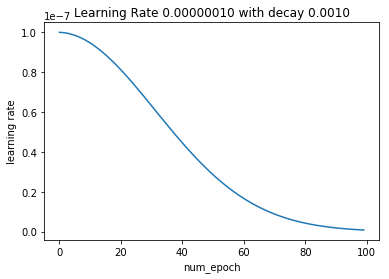

In [460]:
lrate = 1e-7
decay = 1e-3
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

### helper funcs

In [461]:
def nnz_csrrow(m, rownum):
    """ Returns col indices and data that are nonzero in csr matrix m given rownum """
    start, stop = m.indptr[rownum], m.indptr[rownum + 1]
    return m.indices[start:stop], m.data[start:stop]

In [462]:
def update_bias_grad(bias_vector, bias_idx, grad, lr, reg):
    bias_vector[bias_idx] -= lr * grad
    # account for regularization
    bias_vector[bias_idx] *= (1.0 + reg * lr)

In [463]:
def update_latent_vector_grad(latent_vector, idx, grad_vector, lr, reg):
    latent_vector[idx,:] -= lr * grad_vector
    # regularization
    latent_vector[idx,:] *= (1.0 + reg * lr)

In [464]:
def regularize(user_embeddings, item_embeddings, user_biases, item_biases, user_scale, item_scale):
    if not reg:
        return
    item_embeddings /= item_scale
    item_biases /= item_scale
    user_embeddings /= user_scale
    user_biases /= user_scale

In [465]:
# TODO, item_scale and item_alpha (and user_*) are different.

### eval helper funcs

In [502]:
def zero_out_and_count_train(train_mat, preds):
    """ 
    Train is expected to be a csr sparse matrix, preds a dense one.
    Both should have dimensions [users X items]
    """
    num_rows = train_mat.shape[0]
    num_train = np.zeros((num_rows,))
    for row in range(num_rows):
        col_indices, vals = nnz_csrrow(train_mat,  row)
        preds[row, col_indices] = 0
        num_train[row] = col_indices.shape[0]
    return num_train

In [533]:
def compute_auc(item_ranks, num_train, test_mat, remove_train=True):
    """
    We define AUC to be the likelihood of rank inversion for a user's items
    """
    num_users, num_items = item_ranks.shape
    auc = np.zeros((num_users,))
    for user in range(num_users):
        test_item_ids, vals = nnz_csrrow(test_mat,  user)
        num_test_for_u = test_item_ids.shape[0]
        if num_test_for_u == 0:
            auc[user] = 0.5
            continue
        num_train_for_u = num_train[user]
        sorted_test_item_ranks = np.sort(item_ranks[user, test_item_ids])
        num_neg_items = num_items - (num_train_for_u + num_test_for_u)
        for expected_rank, test_rank in enumerate(sorted_test_item_ranks):
            num_rank_inversions = test_rank - expected_rank
            if num_rank_inversions < 0:
                num_rank_inversions = 0
            auc[user] += (1.0 - (num_rank_inversions / num_neg_items))
        if num_test_for_u > 0:
            auc[user] /= num_test_for_u
    return auc

In [534]:
def rank_data(user_embeddings, item_embeddings, item_biases, train_mat, remove_train=True):
    preds = (np.dot(user_embeddings, item_embeddings.T) + item_biases)
    # we don't want to count the training examples in our ranking
    if remove_train:
        num_train = zero_out_and_count_train(train_mat, preds)
    else:
        num_train = np.zeros((user_embeddings.shape[0],))
    return np.argsort(preds, axis=1), num_train

In [535]:
def rank_and_compute_auc(test_mat, train_mat, user_embeddings, item_embeddings, user_biases, item_biases, remove_train=True):
    # for each user, multiply user embedding with item embeddings, and add biases
    # Find rank of test items within all items, excluding train
    # since we only care about the items in the test_mat, we can return a sparse matrix
    # we don't have to account for user bias since it doesn't change ranking - it's the same across all items for each user
    item_ranks, num_train = rank_data(user_embeddings, item_embeddings, item_biases, train_mat, remove_train=remove_train)
    assert np.all(item_ranks >= 0)
    return compute_auc(item_ranks, num_train, test_mat, remove_train=remove_train)

### initialize

In [536]:
# HyperParams
k = 32 # num_factors
max_sampled = 125 # max number of iterations until we find a margin violation
num_epochs = 10
MAX_LOSS = 10 # this is for clipping the loss so our weights don't explode
item_reg = 0.0
user_reg = 0.0
item_scale = 1.0
user_scale = 1.0
MAX_REG_SCALE = 1000000

lr = 1e-7
decay = 1e-3

In [537]:
rand = np.random.RandomState()

In [538]:
def initialize_embeddings(num_users, num_items, k):
    stddev = 1. / math.sqrt(k)
    #math.sqrt(k)
    return {"item" : rand.normal(0, stddev, (num_items, k)), \
            "user" : rand.normal(0, stddev, (num_users, k))}

In [539]:
embeddings = initialize_embeddings(num_users, num_items, k)
user_embeddings = embeddings["user"]
item_embeddings = embeddings["item"]
user_biases = np.zeros((num_users,), dtype=dtype)
item_biases = np.zeros((num_items,), dtype=dtype)

# fit/train

In [540]:
durations = []
auc_scores_test = []
auc_scores_train = []
for epoch in range(num_epochs):
    if decay > 0.0:
        lr *= 1./(1. + decay * epoch)
    start = time.time()
    # shuffle dataset at start of each epoch
    shuffled_users = np.arange(num_users)
    rand.shuffle(shuffled_users)
    for u in range(num_users):
        user_id = shuffled_users[u]
        user_bias, user_embedding = user_biases[user_id], user_embeddings[user_id,:]
        # get user items
        pos_item_idxs, pos_item_ratings = nnz_csrrow(train, user_id)
        pos_item_set = set(pos_item_idxs)
        shuffled_pos_items = np.arange(pos_item_idxs.shape[0])
        rand.shuffle(shuffled_pos_items)
        for pos_item_id in shuffled_pos_items:
            pos_item_bias, pos_item_embedding = item_biases[pos_item_id], item_embeddings[pos_item_id,:]
            
            pos_item_score = safe_sparse_dot(user_embedding, pos_item_embedding) + user_bias + pos_item_bias
            # sample until we find a negative item that violates the margin
            num_sampled = 0
            while num_sampled < max_sampled:
                num_sampled += 1
                neg_item_id = rand.randint(0, num_items)
                if neg_item_id in pos_item_set:
                    continue
                neg_item_bias, neg_item_embedding = item_biases[neg_item_id], item_embeddings[neg_item_id,:]
                neg_item_score = safe_sparse_dot(user_embedding, neg_item_embedding) + user_bias + neg_item_bias
                if pos_item_score > 1 + neg_item_score:
                    continue
                # found a candidate negative item
                loss = math.log(math.floor(num_items / num_sampled))
                if loss > MAX_LOSS:
                    loss = MAX_LOSS
                # update biases
                update_bias_grad(user_biases, user_id, loss, lr, user_reg)
                update_bias_grad(item_biases, neg_item_id, loss, lr, item_reg)
                update_bias_grad(item_biases, pos_item_id, -loss, lr, item_reg)
                # update latent factors
                update_latent_vector_grad(user_embeddings, \
                                          user_id, \
                                          loss * (neg_item_embedding - pos_item_embedding), \
                                          lr, user_reg)
                update_latent_vector_grad(item_embeddings, \
                                          pos_item_id, \
                                          -loss * user_embedding, \
                                          lr, item_reg)
                update_latent_vector_grad(item_embeddings, \
                                          neg_item_id, \
                                          loss * user_embedding, \
                                          lr, item_reg)
                user_scale *= (1.0 + user_reg * lr)
                item_scale *= (1.0 + item_reg * lr)
                break
            if user_scale > MAX_REG_SCALE or item_scale > MAX_REG_SCALE:
                #print("regularizing!")
                regularize(user_embeddings, item_embeddings, user_biases, item_biases, user_scale, item_scale)
                user_scale = 1.0
                item_scale = 1.0
    duration = time.time() - start
    durations.append(duration)    
    auc_score_arr_test = rank_and_compute_auc(test, train, user_embeddings, \
                    item_embeddings, user_biases, item_biases)
    auc_score_test = auc_score_arr_test.mean()
    auc_scores_test.append(auc_score_test)
    auc_score_arr_train = rank_and_compute_auc(train, train, user_embeddings, \
                    item_embeddings, user_biases, item_biases, remove_train=False)
    auc_score_train = auc_score_arr_train.mean()
    auc_scores_train.append(auc_score_train)
    print("iteration %d took %f seconds, auc_test %.4f, auc_train %.4f" % \
        (epoch, duration, auc_score_test, auc_score_train))

iteration 0 took 4.374344 seconds, auc_test 0.4577, auc_train 0.4961
iteration 1 took 4.362473 seconds, auc_test 0.4560, auc_train 0.4973
iteration 2 took 4.321955 seconds, auc_test 0.4591, auc_train 0.4994
iteration 3 took 4.318927 seconds, auc_test 0.4599, auc_train 0.4996
iteration 4 took 4.428538 seconds, auc_test 0.4577, auc_train 0.4992
iteration 5 took 4.321253 seconds, auc_test 0.4598, auc_train 0.4989
iteration 6 took 4.343913 seconds, auc_test 0.4613, auc_train 0.4996
iteration 7 took 4.375854 seconds, auc_test 0.4600, auc_train 0.4965
iteration 8 took 4.367333 seconds, auc_test 0.4582, auc_train 0.4950
iteration 9 took 4.332125 seconds, auc_test 0.4594, auc_train 0.4948


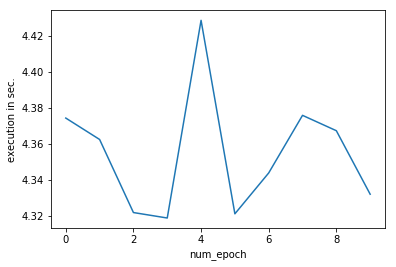

In [541]:
epoch_x = np.arange(num_epochs)
plt.plot(epoch_x, durations)
plt.xlabel("num_epoch")
plt.ylabel("execution in sec.")
plt.show()

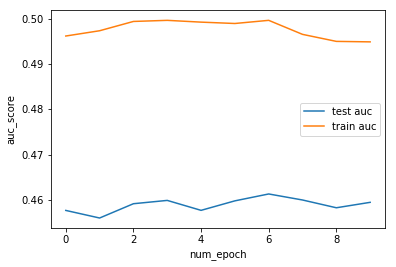

In [542]:
epoch_x = np.arange(num_epochs)
test_line, = plt.plot(epoch_x, auc_scores_test, label="auc test")
train_line, = plt.plot(epoch_x, auc_scores_train, label="auc train")
plt.legend([test_line, train_line], ["test auc", "train auc"])
plt.xlabel("num_epoch")
plt.ylabel("auc_score")
plt.show()